## Phasic Policy Gradients
The purpose of this notebook is to implement OpenAI's [phasic policy gradients](https://arxiv.org/abs/2009.04416) algorithm from scratch and compare it to A2C and PPO on Gym's LunarLander environment.

We'll write each algorithm from scratch, incrementally building up to phasic policy gradients.

Our PPG implementation closely follows the implementation used in the original paper, with the only real difference being that the environment we're using (LunarLander) is significantly more simple than the [Procgen](https://arxiv.org/abs/1912.01588) environments used to evaluate PPG in its paper. Consequently, our network architecture is far more simple, and the model will likely benefit less from feature distillation.

In [1]:
# To run LunarLander in Kaggle we need to install these two packages
!pip install swig --quiet
!pip install gym[box2d] --quiet

## A2C Baseline
We use a simple A2C implementation for our baseline. This implementation features:
- Generalised Advantage Estimation (GAE)
- An entropy bonus added to loss, to aid exploration
- Separate actor and critic networks, experimentally this was found to give better performance in both A2C and PPO
- Simple actor and critic networks with a single hidden layer of 128 neurons
- Tanh activation for the actor and critic networks
- Advantage normalisation (technically advantages are just divided by the std of all advantages in the batch)
- Global gradient clipping
- Reward clipping and scaling

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from collections import deque

a2c_config = {
    'device'        :  'cuda' if torch.cuda.is_available() else 'cpu',
    'lr'            :  5e-4,  # Optimiser learning rate
    'hidden_size'   :   128,  # Number of neurons in network hidden layer
    'gamma'         : 0.999,  # Discount factor
    'rollout_steps' :   256,  # Number of steps per rollout before learning
    'beta'          :  0.01,  # Weight of entropy loss
    'lambda'        :  0.95,  # GAE lambda
    'advantage_norm':  True,  # Standardise advantages
    'value_loss'    :     1,  # Weight of value loss  
    'target_reward' :   200,  # Training is halted when this average reward is reached
    'grad_clip'     :   0.5,  # Global gradient clipping value
    'clip_rewards'  :  True,  # Clip rewards to a certain range
    'reward_clip'   :    20,  # Rewards will be clipped between +-reward_clip
    'scale_rewards' :  True,  # Scale rewards by dividing by their standard deviation
}
    
class ActorCriticNetwork(nn.Module):
    def __init__(self, observation_space, action_space, hidden_size=64):
        super().__init__()
        obs_length  = np.prod(observation_space.shape)
        n_actions   = action_space.n
        
        self.actor = nn.Sequential(
            nn.Linear(obs_length,  hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, n_actions)
        )
        self.actor[-1].weight.data *= 0.01
        
        self.critic = nn.Sequential(
            nn.Linear(obs_length,  hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, x):
        return self.actor(x), self.critic(x)
    
class A2C:
    def __init__(self, config, observation_space, action_space):
        self.device = config['device']
        self.config = config
        self.buffer = deque(maxlen=config['rollout_steps'])
        self.network = ActorCriticNetwork(observation_space, action_space, config['hidden_size']).to(self.device)
        self.optimizer = torch.optim.AdamW(self.network.parameters(), lr=config['lr'])

    def select_action(self, observation, deterministic=False):
        with torch.no_grad():
            state_tensor = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)
            logits = self.network.actor(state_tensor)
            if deterministic:
                return logits.argmax(1).item()
            return torch.distributions.Categorical(logits=logits).sample().item()
    
    def step(self, experience):
        self.buffer.append(experience)
        if len(self.buffer) == self.buffer.maxlen:
            self.learn()
            self.buffer.clear()
    
    def learn(self):
        # Unpack experiences from buffer and convert to tensors
        states, actions, rewards, next_states, dones = zip(*self.buffer)
        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(np.array(actions), dtype=torch.long, device=self.device)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32, device=self.device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        dones = torch.tensor(np.array(dones), dtype=torch.float32, device=self.device)
        logits, values = self.network(states)
        values = values.squeeze(1)
        
        # Clip and scale rewards
        if self.config['clip_rewards']:
            rewards = torch.clamp(rewards, min=-self.config['reward_clip'], max=self.config['reward_clip'])
        if self.config['scale_rewards']:
            rewards /= rewards.std()
    
        # GAE calculation
        with torch.no_grad():
            next_value = self.network.critic(next_states[-1].unsqueeze(0)).item()
            advantages = torch.zeros_like(rewards, device=self.device)
            lastgaelam = 0.
            for t in reversed(range(self.config['rollout_steps'])):
                if t == self.config['rollout_steps'] - 1:
                    next_non_terminal = 1.0 - dones[-1]
                    next_values = next_value
                else:
                    next_non_terminal = 1.0 - dones[t + 1]
                    next_values = values[t + 1]
                delta = rewards[t] + self.config['gamma'] * next_values * next_non_terminal - values[t]
                advantages[t] = lastgaelam = delta + self.config['gamma'] * self.config['lambda'] * next_non_terminal * lastgaelam
            returns = advantages + values
            
        # Normalise advantages
        if self.config['advantage_norm']:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Policy loss using the calculated advantages
        distribution = torch.distributions.Categorical(logits=logits)
        log_probs = distribution.log_prob(actions)

        # Policy loss, value loss and entropy bonus
        loss = -(log_probs * advantages).mean() + \
               self.config['value_loss'] * F.mse_loss(values, returns) + \
               -self.config['beta'] * distribution.entropy().mean()

        # Actor network update
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.network.parameters(), self.config['grad_clip'])
        self.optimizer.step()

/home/alex/PyVirtualEnvs/TorchEnv/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)

  return torch._C._cuda_getDeviceCount() > 0


In [3]:
import gymnasium as gym
import numpy as np

def train_agent(env_name, agent_function, agent_config, total_steps=1000000, reward_target=True):
    import gymnasium as gym
    
    # Initialize environment and agent
    env = gym.make(env_name)
    observation, _ = env.reset()
    agent = agent_function(agent_config, env.observation_space, env.action_space)

    # Tracking variables
    step = 1
    episode = 1
    episodic_reward = 0.
    episode_rewards = []

    for step in range(1, total_steps + 1):
        action = agent.select_action(observation)
        next_observation, reward, termination, truncation, _ = env.step(action)
        done = termination or truncation

        agent.step((observation, action, reward, next_observation, done))

        # Update rewards and reset if done
        episodic_reward += reward

        if done:
            observation, _ = env.reset()
            episode += 1
            episode_rewards.append(episodic_reward)
            episodic_reward = 0.
            print(f"\r---\tStep: {step}/{total_steps}\t Avg reward: {np.mean(episode_rewards[-20:]):.1f}\t Episodes Done: {episode:,}\t ---", end='')
            if episode % 100 == 0:
                print()
        else:
            observation = next_observation
            
            if reward_target and (np.mean(episode_rewards[-20:]) >= agent_config['target_reward']): break
    return agent, episode_rewards

a2c_agent, a2c_rewards = train_agent('LunarLander-v2', A2C, a2c_config)

/home/alex/PyVirtualEnvs/TorchEnv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.

  return _methods._mean(a, axis=axis, dtype=dtype,

/home/alex/PyVirtualEnvs/TorchEnv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide

  ret = ret.dtype.type(ret / rcount)


---	Step: 9658/1000000	 Avg reward: -138.8	 Episodes Done: 100	 ---

---	Step: 19197/1000000	 Avg reward: -197.1	 Episodes Done: 200	 ---

---	Step: 30766/1000000	 Avg reward: -128.9	 Episodes Done: 300	 ---

---	Step: 44744/1000000	 Avg reward: -168.4	 Episodes Done: 400	 ---

---	Step: 60655/1000000	 Avg reward: -100.7	 Episodes Done: 500	 ---

---	Step: 71805/1000000	 Avg reward: -56.4	 Episodes Done: 600	 ----

---	Step: 90823/1000000	 Avg reward: -31.0	 Episodes Done: 700	 ---

---	Step: 129408/1000000	 Avg reward: 3.2	 Episodes Done: 800	 -----

---	Step: 165630/1000000	 Avg reward: 28.1	 Episodes Done: 900	 ---

---	Step: 205264/1000000	 Avg reward: 10.4	 Episodes Done: 1,000	 ---

---	Step: 255245/1000000	 Avg reward: 89.1	 Episodes Done: 1,100	 ----

---	Step: 299910/1000000	 Avg reward: 42.3	 Episodes Done: 1,200	 ----

---	Step: 348133/1000000	 Avg reward: -41.5	 Episodes Done: 1,300	 ----

---	Step: 399594/1000000	 Avg reward: 94.3	 Episodes Done: 1,400	 -----

---	Step: 43

## PPO Implementation
We use a PPO implementation with a few of the staple performance enhancing tweaks:
- Many of the same features of the A2C implementation above; GAE, an entropy bonus, separate actor and critic networks with a single hidden layer and tanh activation, advantage normalisation, global gradient clipping and reward clipping and scaling as well as:
- Reuse of rollout data for several training epochs
- Rollout data is split into several minibatches for each of the above training epochs
- PPO clipping is used as standard

In [4]:
ppo_config = {
    'device'        :  'cuda' if torch.cuda.is_available() else 'cpu',
    'lr'            :  5e-4,  # Optimiser learning rate
    'hidden_size'   :   128,  # Number of neurons in network hidden layer
    'gamma'         : 0.999,  # Discount factor
    'rollout_steps' :   256,  # Number of steps per rollout before learning
    'beta'          :  0.01,  # Weight of entropy loss
    'lambda'        :  0.95,  # GAE lambda
    'advantage_norm':  True,  # Standardise advantages
    'n_epochs'      :     3,  # Number of times collected experiences are used for training
    'n_minibatches' :     8,  # Number of minibatches collected experiences are broken into
    'value_loss'    :     1,  # Weight of value loss  
    'target_reward' :   200,  # Training is halted when this average reward is reached
    'ppo_clip'      :   0.2,  # PPO policy ratio clip value
    'grad_clip'     :   0.5,  # Global gradient clipping value
    'clip_rewards'  :  True,  # Clip rewards to a certain range
    'reward_clip'   :    20,  # Rewards will be clipped between +-reward_clip
    'scale_rewards' :  True,  # Scale rewards by dividing by their standard deviation
}
    
class ActorCriticNetwork(nn.Module):
    def __init__(self, observation_space, action_space, hidden_size=64):
        super().__init__()
        obs_length  = np.prod(observation_space.shape)
        n_actions   = action_space.n
        
        self.actor = nn.Sequential(
            nn.Linear(obs_length,  hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, n_actions)
        )
        self.actor[-1].weight.data *= 0.01
        
        self.critic = nn.Sequential(
            nn.Linear(obs_length,  hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, x):
        return self.actor(x), self.critic(x)
    
class PPO:
    def __init__(self, config, observation_space, action_space):
        self.device = config['device']
        self.config = config
        self.buffer = deque(maxlen=config['rollout_steps'])
        self.network = ActorCriticNetwork(observation_space, action_space, config['hidden_size']).to(self.device)
        self.optimizer = torch.optim.AdamW(self.network.parameters(), lr=config['lr'])

    def select_action(self, observation, deterministic=False):
        with torch.no_grad():
            state_tensor = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)
            logits = self.network.actor(state_tensor)
            if deterministic:
                return logits.argmax(1).item()
            return torch.distributions.Categorical(logits=logits).sample().item()
    
    def step(self, experience):
        self.buffer.append(experience)
        if len(self.buffer) == self.buffer.maxlen:
            self.learn()
            self.buffer.clear()
    
    def learn(self):
        # Unpack experiences from buffer and convert to tensors
        states, actions, rewards, next_states, dones = zip(*self.buffer)
        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(np.array(actions), dtype=torch.long, device=self.device)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32, device=self.device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        dones = torch.tensor(np.array(dones), dtype=torch.float32, device=self.device)
        
        # Clip and scale rewards
        if self.config['clip_rewards']:
            rewards = torch.clamp(rewards, min=-self.config['reward_clip'], max=self.config['reward_clip'])
        if self.config['scale_rewards']:
            rewards /= rewards.std()
    
        with torch.no_grad():
             # Forward pass with original parameters
            logits = self.network.actor(states)
            log_probs = torch.distributions.Categorical(logits=logits).log_prob(actions)
            values = self.network.critic(states).squeeze(1)
            
            # GAE calculation
            next_value = self.network.critic(next_states[-1].unsqueeze(0)).item()
            advantages = torch.zeros_like(rewards, device=self.device)
            lastgaelam = 0.
            for t in reversed(range(self.config['rollout_steps'])):
                if t == self.config['rollout_steps'] - 1:
                    next_non_terminal = 1.0 - dones[-1]
                    next_values = next_value
                else:
                    next_non_terminal = 1.0 - dones[t + 1]
                    next_values = values[t + 1]
                delta = rewards[t] + self.config['gamma'] * next_values * next_non_terminal - values[t]
                advantages[t] = lastgaelam = delta + self.config['gamma'] * self.config['lambda'] * next_non_terminal * lastgaelam
            returns = advantages + values
        
            # Normalise advantages
            if self.config['advantage_norm']:
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
                
        # Generate batch and minibatch indices
        b_indices = np.arange(len(states))
        minibatch_size = len(states) // self.config['n_minibatches']
        for epoch in range(self.config['n_epochs']):
            np.random.shuffle(b_indices)
            for minibatch in range(self.config['n_minibatches']):
                start = minibatch * minibatch_size
                end = start + minibatch_size
                mb_indices = b_indices[start:end]
                
                # Forward pass with current parameters
                new_logits, new_values = self.network(states[mb_indices])

                # Policy loss
                distribution = torch.distributions.Categorical(logits=new_logits)
                new_log_probs = distribution.log_prob(actions[mb_indices])
                ratio = (new_log_probs - log_probs[mb_indices]).exp()
                loss_surrogate_unclipped = -advantages[mb_indices] * ratio
                loss_surrogate_clipped = -advantages[mb_indices] * torch.clamp(ratio, 
                                                                               1 - self.config['ppo_clip'], 
                                                                               1 + self.config['ppo_clip'])
                loss_policy = torch.max(loss_surrogate_unclipped, loss_surrogate_clipped).mean()

                # Value loss
                loss_value = F.mse_loss(new_values.squeeze(1), returns[mb_indices])
                
                # Entropy loss
                entropy = distribution.entropy().mean()
                
                # Combined weighted losses
                loss = loss_policy + \
                       self.config['value_loss'] * loss_value + \
                      -self.config['beta'] * entropy

                # Network update and global gradient clipping
                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.network.parameters(), self.config['grad_clip'])
                self.optimizer.step()

In [5]:
ppo_agent, ppo_rewards = train_agent('LunarLander-v2', PPO, ppo_config)

---	Step: 13200/1000000	 Avg reward: -48.7	 Episodes Done: 100	 ---

---	Step: 49285/1000000	 Avg reward: 47.8	 Episodes Done: 200	 ----

---	Step: 93916/1000000	 Avg reward: 110.9	 Episodes Done: 300	 ---

---	Step: 139171/1000000	 Avg reward: 22.6	 Episodes Done: 400	 ----

---	Step: 170547/1000000	 Avg reward: 107.0	 Episodes Done: 500	 ---

---	Step: 211565/1000000	 Avg reward: 59.2	 Episodes Done: 600	 ----

---	Step: 240428/1000000	 Avg reward: 87.6	 Episodes Done: 700	 ----

---	Step: 270033/1000000	 Avg reward: 71.7	 Episodes Done: 800	 ----

---	Step: 306729/1000000	 Avg reward: 101.2	 Episodes Done: 900	 ---

---	Step: 342503/1000000	 Avg reward: 113.3	 Episodes Done: 1,000	 ---

---	Step: 346872/1000000	 Avg reward: 201.9	 Episodes Done: 1,009	 ---

## Phasic Policy Gradients (PPG) Implementation
Phasic Policy Gradients (PPG) is an extension of PPO. It enhances PPO by using two distinct network architectures - a policy network and a value network, while also incorporating an additional value head on the policy network. This auxiliary value head helps in feature distillation by predicting value as a side task.

PPG divides its training into two main phases:

#### Policy phase
This phase involves independent training of the actor and critic networks, much like the standard practice in PPO.

#### Auxiliary phase
This phase consists of two parts:
1. **Value Head Training**: The auxiliary value head is trained, which also includes a behavior cloning loss. This loss prevents significant deviations in the policy while it learns from the value targets. 
2. **Critic Training**: The separate critic network is trained using a broader set of historical data, allowing for more extensive critic learning than typically occurs in PPO.

PPG aims to leverage the strengths of having both separate and shared functions for policy and value, enhancing the training and performance of the value function beyond what is common in PPO.

In [6]:
ppg_config = {
    'device'         :  'cuda' if torch.cuda.is_available() else 'cpu',
    'lr'             :  5e-4,  # Optimiser learning rate
    'hidden_size'    :   64,  # Number of neurons in network hidden layer
    'gamma'          : 0.999,  # Discount factor
    'rollout_steps'  :   256,  # Number of steps per rollout before learning
    'beta'           :  0.01,  # Weight of entropy loss
    'lambda'         :  0.95,  # GAE lambda
    'advantage_norm' :  True,  # Standardise advantages
    'policy_epochs'  :     1,  # Number of times collected experiences are used for training policy  (Eπ in paper)
    'value_epochs'   :     1,  # Number of epochs used to train value network                        (Ev in paper)
    'n_minibatches'  :     8,  # Number of minibatches collected experiences are broken into
    'value_loss'     :     1,  # Weight of value loss  
    'target_reward'  :   200,  # Training is halted when this average reward is reached
    'ppo_clip'       :   0.2,  # PPO policy ratio clip value
    'grad_clip'      :   0.5,  # Global gradient clipping value
    'clip_rewards'   :  True,  # Clip rewards to a certain range
    'reward_clip'    :    20,  # Rewards will be clipped between +-reward_clip
    'scale_rewards'  :  True,  # Scale rewards by dividing by their standard deviation
    'aux_epochs'     :     9,  # Number of auxiliary phases                                          (Eaux in paper)
    'aux_minibatches':    16,  # Number of minibatches used during auxiliary phase
    'clone_beta'     :     1,  # Weight of behaviour cloning penalty in aux loss
    'aux_frequency'  :    32,  # Frequency of auxiliary phases relative to policy phases             (Nπ in paper)
}
    
class PPGNetwork(nn.Module):
    def __init__(self, observation_space, action_space, hidden_size=64):
        super().__init__()
        obs_length  = np.prod(observation_space.shape)
        n_actions   = action_space.n
        
        # Shared base with policy and value heads
        self.base = nn.Sequential(
            nn.Linear(obs_length,  hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh()
        )
        self.policy_head = nn.Linear(hidden_size, n_actions)
        self.policy_head.weight.data *= 0.01
        self.value_head = nn.Linear(hidden_size, 1)
        
        # Actor that uses shared base and policy head
        self.actor = nn.Sequential(
            self.base,
            self.policy_head
        )
        
        # Separate critic
        self.critic = nn.Sequential(
            nn.Linear(obs_length, 2 * hidden_size),
            nn.Tanh(),
            nn.Linear(2 * hidden_size, 2 * hidden_size),
            nn.Tanh(),
            nn.Linear(2 * hidden_size, 1)
        )
        
        # Auxiliary critic used for feature distillation
        self.critic_aux = nn.Sequential(
            self.base,
            self.value_head
        )
        
    def forward(self, x):
        return self.actor(x), self.critic(x)
    
class PPG:
    def __init__(self, config, observation_space, action_space):
        self.device = config['device']
        self.config = config
        self.buffer = deque(maxlen=config['rollout_steps'])
        self.aux_buffer = deque(maxlen=config['rollout_steps'] * config['aux_frequency'])
        self.network = PPGNetwork(observation_space, action_space, config['hidden_size']).to(self.device)
        self.optimizer = torch.optim.AdamW(self.network.parameters(), lr=config['lr'])
        self.step_counter = 0

    def select_action(self, observation, deterministic=False):
        with torch.no_grad():
            state_tensor = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)
            logits = self.network.actor(state_tensor)
            if deterministic:
                return logits.argmax(1).item()
            return torch.distributions.Categorical(logits=logits).sample().item()
    
    def step(self, experience):
        self.buffer.append(experience)
        self.aux_buffer.append(experience)
        if len(self.buffer) == self.buffer.maxlen:
            self.learn()
            self.buffer.clear()
        self.step_counter += 1
    
    def learn(self):
        # Unpack experiences from buffer and convert to tensors
        states, actions, rewards, next_states, dones = zip(*self.buffer)
        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(np.array(actions), dtype=torch.long, device=self.device)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32, device=self.device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        dones = torch.tensor(np.array(dones), dtype=torch.float32, device=self.device)
        
        # Clip and scale rewards
        if self.config['clip_rewards']:
            rewards = torch.clamp(rewards, min=-self.config['reward_clip'], max=self.config['reward_clip'])
        if self.config['scale_rewards']:
            rewards /= rewards.std()
    
        with torch.no_grad():
             # Forward pass with original parameters
            logits = self.network.actor(states)
            log_probs = torch.distributions.Categorical(logits=logits).log_prob(actions)
            values = self.network.critic(states).squeeze(1)
            
            # GAE calculation
            next_value = self.network.critic(next_states[-1].unsqueeze(0)).item()
            advantages = torch.zeros_like(rewards, device=self.device)
            lastgaelam = 0.
            for t in reversed(range(self.config['rollout_steps'])):
                if t == self.config['rollout_steps'] - 1:
                    next_non_terminal = 1.0 - dones[-1]
                    next_values = next_value
                else:
                    next_non_terminal = 1.0 - dones[t + 1]
                    next_values = values[t + 1]
                delta = rewards[t] + self.config['gamma'] * next_values * next_non_terminal - values[t]
                advantages[t] = lastgaelam = delta + self.config['gamma'] * self.config['lambda'] * next_non_terminal * lastgaelam
            returns = advantages + values
        
            # Normalise advantages
            if self.config['advantage_norm']:
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
                
        # Policy Phase
        # Generate batch and minibatch indices
        b_indices = np.arange(len(states))
        minibatch_size = len(states) // self.config['n_minibatches']
        for epoch in range(self.config['policy_epochs']):
            np.random.shuffle(b_indices)
            for minibatch in range(self.config['n_minibatches']):
                start = minibatch * minibatch_size
                end = start + minibatch_size
                mb_indices = b_indices[start:end]
                
                # Forward pass with current parameters
                new_logits = self.network.actor(states[mb_indices])

                # Policy loss
                distribution = torch.distributions.Categorical(logits=new_logits)
                new_log_probs = distribution.log_prob(actions[mb_indices])
                ratio = (new_log_probs - log_probs[mb_indices]).exp()
                loss_surrogate_unclipped = -advantages[mb_indices] * ratio
                loss_surrogate_clipped = -advantages[mb_indices] * torch.clamp(ratio, 
                                                                               1 - self.config['ppo_clip'], 
                                                                               1 + self.config['ppo_clip'])
                loss_policy = torch.max(loss_surrogate_unclipped, loss_surrogate_clipped).mean()

                # Entropy loss
                entropy = distribution.entropy().mean()
                
                # Policy loss
                loss = loss_policy - self.config['beta'] * entropy

                # Network update and global gradient clipping
                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.network.parameters(), self.config['grad_clip'])
                self.optimizer.step()

        for epoch in range(self.config['value_epochs']):
            np.random.shuffle(b_indices)
            for minibatch in range(self.config['n_minibatches']):
                # Forward pass with critic
                new_values = self.network.critic(states[mb_indices])

                # Value loss
                loss_value = F.mse_loss(new_values.squeeze(1), returns[mb_indices])
                loss = self.config['value_loss'] * loss_value 
                
                # Network update and global gradient clipping
                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.network.parameters(), self.config['grad_clip'])
                self.optimizer.step()
                
        # Auxiliary Phase
        if self.step_counter % self.config['aux_frequency'] != 0: return
        states, actions, rewards, next_states, dones = zip(*self.aux_buffer)
        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(np.array(actions), dtype=torch.long, device=self.device)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32, device=self.device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        dones = torch.tensor(np.array(dones), dtype=torch.float32, device=self.device)
        
        # Clip and scale rewards
        if self.config['clip_rewards']:
            rewards = torch.clamp(rewards, min=-self.config['reward_clip'], max=self.config['reward_clip'])
        if self.config['scale_rewards']:
            rewards /= rewards.std()
    
        with torch.no_grad():
             # Forward pass with original parameters
            logits = self.network.actor(states)
            log_probs = torch.distributions.Categorical(logits=logits).log_prob(actions)
            values = self.network.critic(states).squeeze(1)
            
            # GAE calculation
            next_value = self.network.critic(next_states[-1].unsqueeze(0)).item()
            advantages = torch.zeros_like(rewards, device=self.device)
            lastgaelam = 0.
            for t in reversed(range(self.config['rollout_steps'])):
                if t == self.config['rollout_steps'] - 1:
                    next_non_terminal = 1.0 - dones[-1]
                    next_values = next_value
                else:
                    next_non_terminal = 1.0 - dones[t + 1]
                    next_values = values[t + 1]
                delta = rewards[t] + self.config['gamma'] * next_values * next_non_terminal - values[t]
                advantages[t] = lastgaelam = delta + self.config['gamma'] * self.config['lambda'] * next_non_terminal * lastgaelam
            returns = advantages + values
        
            # Normalise advantages
            if self.config['advantage_norm']:
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
            
        for epoch in range(self.config['aux_epochs']):
            np.random.shuffle(b_indices)
            for minibatch in range(self.config['n_minibatches']):
                start = minibatch * minibatch_size
                end = start + minibatch_size
                mb_indices = b_indices[start:end]
                
                # Calculate the auxiliary value head predictions
                enc = self.network.base(states[mb_indices])
                new_logits = self.network.policy_head(enc)
                aux_values = self.network.value_head(enc).squeeze(1)

                # Auxiliary loss
                aux_loss = F.mse_loss(aux_values, returns[mb_indices])

                # Behaviour cloning loss
                new_logits = self.network.actor(states[mb_indices])
                old_dist = torch.distributions.Categorical(logits=logits[mb_indices])
                new_dist = torch.distributions.Categorical(logits=new_logits)
                kl_loss = torch.distributions.kl_divergence(old_dist, new_dist).mean()

                # Value loss
                new_values = self.network.critic(states[mb_indices])
                loss_value = F.mse_loss(new_values.squeeze(1), returns[mb_indices])

                # Joint loss
                joint_loss = aux_loss + self.config['clone_beta'] * kl_loss + self.config['value_loss'] * loss_value 

                # Network update and global gradient clipping
                self.optimizer.zero_grad()
                joint_loss.backward()
                nn.utils.clip_grad_norm_(self.network.parameters(), self.config['grad_clip'])
                self.optimizer.step()
                

In [7]:
ppg_agent, ppg_rewards = train_agent('LunarLander-v2', PPG, ppg_config)

---	Step: 9183/1000000	 Avg reward: -142.6	 Episodes Done: 100	 ---

---	Step: 21898/1000000	 Avg reward: -81.4	 Episodes Done: 200	 ----

---	Step: 46097/1000000	 Avg reward: 19.7	 Episodes Done: 300	 ----

---	Step: 87457/1000000	 Avg reward: 14.1	 Episodes Done: 400	 ----

---	Step: 133848/1000000	 Avg reward: 122.6	 Episodes Done: 500	 ---

---	Step: 173798/1000000	 Avg reward: 72.4	 Episodes Done: 600	 ----

---	Step: 206524/1000000	 Avg reward: 103.9	 Episodes Done: 700	 ---

---	Step: 244940/1000000	 Avg reward: 70.4	 Episodes Done: 800	 ----

---	Step: 280783/1000000	 Avg reward: 96.2	 Episodes Done: 900	 ----

---	Step: 305523/1000000	 Avg reward: 2.6	 Episodes Done: 1,000	 ---

---	Step: 330127/1000000	 Avg reward: 133.2	 Episodes Done: 1,100	 ---

---	Step: 367426/1000000	 Avg reward: 126.0	 Episodes Done: 1,200	 ---

---	Step: 393762/1000000	 Avg reward: 33.8	 Episodes Done: 1,300	 ----

---	Step: 421359/1000000	 Avg reward: 121.8	 Episodes Done: 1,400	 ---

---	Step: 44797

## Comparing A2C, PPO and PPG

We'll train each model for 1 million steps on LunarLander to compare their performances. A score of 200 is considered solved.

The reward target is removed so agents continue training and can learn to obtain higher scores.

In [8]:
import pickle

rewards = {'a2c': [], 'ppo': [], 'ppg': []}

n_runs = 10

for run in range(n_runs):
    _, a2c_rewards = train_agent('LunarLander-v2', A2C, a2c_config, reward_target=False)
    _, ppo_rewards = train_agent('LunarLander-v2', PPO, ppo_config, reward_target=False)
    _, ppg_rewards = train_agent('LunarLander-v2', PPG, ppg_config, reward_target=False)
    
    rewards['a2c'].append(a2c_rewards)
    rewards['ppo'].append(ppo_rewards)
    rewards['ppg'].append(ppg_rewards)
    
# Save rewards dict
filename = 'rewards.pkl'

# Open a file in binary write mode
with open(filename, 'wb') as file:
    pickle.dump(rewards, file)

---	Step: 9728/1000000	 Avg reward: -193.1	 Episodes Done: 100	 ---

---	Step: 21118/1000000	 Avg reward: -228.0	 Episodes Done: 200	 ---

---	Step: 33746/1000000	 Avg reward: -173.4	 Episodes Done: 300	 ---

---	Step: 46741/1000000	 Avg reward: -139.7	 Episodes Done: 400	 ---

---	Step: 62932/1000000	 Avg reward: -44.5	 Episodes Done: 500	 ----

---	Step: 82692/1000000	 Avg reward: -27.9	 Episodes Done: 600	 ---

---	Step: 118515/1000000	 Avg reward: -19.1	 Episodes Done: 700	 ---

---	Step: 151702/1000000	 Avg reward: -3.6	 Episodes Done: 800	 ----

---	Step: 192457/1000000	 Avg reward: 35.8	 Episodes Done: 900	 ----

---	Step: 227144/1000000	 Avg reward: 99.5	 Episodes Done: 1,000	 ---

---	Step: 255183/1000000	 Avg reward: 25.4	 Episodes Done: 1,100	 ----

---	Step: 276237/1000000	 Avg reward: 13.5	 Episodes Done: 1,200	 ----

---	Step: 297316/1000000	 Avg reward: 19.4	 Episodes Done: 1,300	 ----

---	Step: 321250/1000000	 Avg reward: -22.1	 Episodes Done: 1,400	 ---

---	Step: 349

### Plot Curves Comparing Performances

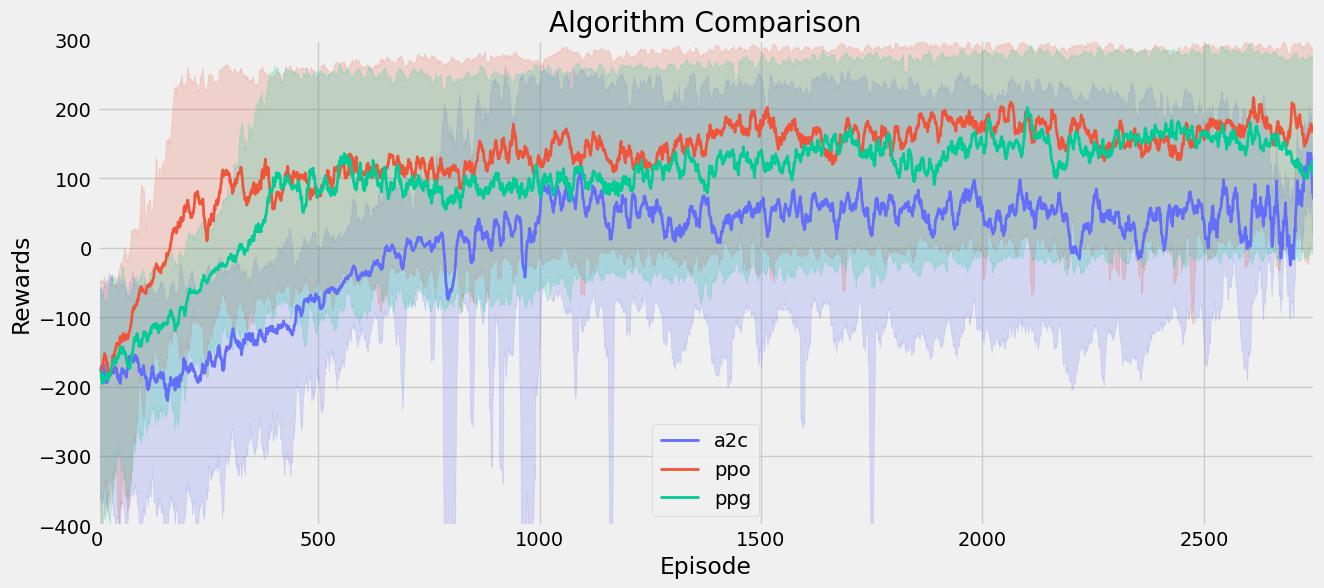

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')

def moving_average(data, window_size):
    """Calculate the moving average using a window size."""
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

def plot_rewards(rewards_dict):
    plt.figure(figsize=(14, 6))

    colors = {'a2c': '#636EFA', 'ppo': '#EF553B', 'ppg': '#00CC96'}
    
    for method, color in colors.items():
        # Extract all episodes' lengths to find the maximum number of episodes any run went through
        max_episodes = max(len(run) for run in rewards_dict[method])
        
        # Initialize a list to hold all reward values per episode index
        reward_collection = [[] for _ in range(max_episodes)]
        
        # Organize rewards by episode index
        for run in rewards_dict[method]:
            for index, reward in enumerate(run):
                if index < len(reward_collection):
                    reward_collection[index].append(reward)
        
        # Calculate the mean, min, and max rewards for each episode index
        mean_rewards = [np.mean(rewards) if rewards else None for rewards in reward_collection]
        min_rewards = [np.min(rewards) if rewards else None for rewards in reward_collection]
        max_rewards = [np.max(rewards) if rewards else None for rewards in reward_collection]
        
        # Apply moving average smoothing to the mean rewards
        if len(mean_rewards) >= 10:
            mean_rewards = moving_average(mean_rewards, 10)
            min_rewards = moving_average(min_rewards, 10)
            max_rewards = moving_average(max_rewards, 10)
            episodes = range(9, len(mean_rewards) + 9)  # Adjust episode start index due to moving average
        else:
            episodes = range(len(mean_rewards))
        
        # Plotting the mean line
        plt.plot(episodes, mean_rewards, label=f'{method}', color=color, linewidth=2)
        
        # Shaded area between min and max
        plt.fill_between(episodes, min_rewards, max_rewards, color=color, alpha=0.2)
    
    plt.title('Algorithm Comparison')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.legend(loc='lower center')
    plt.grid(True)
    plt.ylim(-400, 300)  # Setting y-axis limits
    plt.xlim(0, 2750)  # Setting x-axis limits
    plt.show()

plot_rewards(rewards)